# Qiskit config

In [1]:
from qiskit import transpile
from qiskit.providers.aer.backends import AerSimulator

# Qclib

In [2]:
import numpy as np
import random
import sys
sys.path.append('../../')
from qclib.state_preparation.baa_schmidt import initialize

In [11]:
def _overlap(input_state, transpiled_circuit):
    backend = AerSimulator()
    transpiled_circuit.save_statevector()
    ket = backend.run(transpiled_circuit).result().get_statevector()
    bra = np.conj(input_state)

    return np.abs(bra.dot(ket))**2

def _counts(input_state, l=0.0, result=None, strategy='brute_force', max_k=0):
    circuit = initialize(input_state, max_fidelity_loss=l, strategy=strategy, max_combination_size=max_k)
    transpiled_circuit = transpile(circuit, basis_gates=['u1','u2','u3', 'cx'], optimization_level=3)

    count_ops = transpiled_circuit.count_ops()
    n_cx = 0
    if 'cx' in count_ops:
        n_cx = count_ops['cx']
    n_dp = transpiled_circuit.depth()
    
    overlap = _overlap(input_state, transpiled_circuit)

    if result is not None:
        result.append([l, n_cx, n_dp, overlap])

    print('\tCNOTs = {0}\tdepth = {1}\toverlap={2}'.format(n_cx, n_dp, overlap))

def _grid_search(input_state, strategy='brute_force', max_k=0, fidelity_loss=None):
    result = []
    if fidelity_loss is None:
        fidelity_loss = [i/100 for i in range(100)]

    n = int(np.log2(len(input_state)))
    for l in fidelity_loss:
        print('loss = {0}:'.format(l), end='')
        _counts(input_state, l=l, result=result, strategy=strategy, max_k=max_k)
        if result is not None and result[-1][1] == 0:
            break

    return result

# Fixed state

In [12]:
input_state = [-0.33*1j,0,-0.44-0.44*1j,0.24+0.23*1j,0,0,0,0.62-0.01*1j]
input_state = input_state/np.linalg.norm(input_state)

_grid_search(input_state);

loss = 0.0:	CNOTs = 3	depth = 7	overlap=1.0000000000000009
loss = 0.01:	CNOTs = 3	depth = 7	overlap=1.0000000000000009
loss = 0.02:	CNOTs = 3	depth = 7	overlap=1.0000000000000009
loss = 0.03:	CNOTs = 3	depth = 7	overlap=1.0000000000000009
loss = 0.04:	CNOTs = 3	depth = 7	overlap=1.0000000000000009
loss = 0.05:	CNOTs = 3	depth = 7	overlap=1.0000000000000009
loss = 0.06:	CNOTs = 1	depth = 3	overlap=0.941726180817804
loss = 0.07:	CNOTs = 1	depth = 3	overlap=0.941726180817804
loss = 0.08:	CNOTs = 1	depth = 3	overlap=0.941726180817804
loss = 0.09:	CNOTs = 1	depth = 3	overlap=0.941726180817804
loss = 0.1:	CNOTs = 1	depth = 3	overlap=0.941726180817804
loss = 0.11:	CNOTs = 1	depth = 3	overlap=0.941726180817804
loss = 0.12:	CNOTs = 1	depth = 3	overlap=0.941726180817804
loss = 0.13:	CNOTs = 1	depth = 3	overlap=0.941726180817804
loss = 0.14:	CNOTs = 1	depth = 3	overlap=0.941726180817804
loss = 0.15:	CNOTs = 1	depth = 3	overlap=0.941726180817804
loss = 0.16:	CNOTs = 1	depth = 3	overlap=0.941726180

# Uniform state

In [13]:
min_n = 3
max_n = 10

for n in range(min_n, max_n+1):
    input_state = np.ones(2**n)
    input_state = input_state/np.linalg.norm(input_state)

    print('n = {0}'.format(n), end='')
    _counts(input_state, strategy='greedy')


n = 3	CNOTs = 0	depth = 1	overlap=1.0
n = 4	CNOTs = 0	depth = 1	overlap=1.0
n = 5	CNOTs = 0	depth = 1	overlap=0.9999999999999998
n = 6	CNOTs = 0	depth = 1	overlap=0.9999999999999998
n = 7	CNOTs = 0	depth = 1	overlap=0.9999999999999998
n = 8	CNOTs = 0	depth = 1	overlap=0.9999999999999996
n = 9	CNOTs = 0	depth = 1	overlap=0.9999999999999996
n = 10	CNOTs = 0	depth = 1	overlap=0.9999999999999996


# Random rank 1 state

In [7]:
rnd = np.random.RandomState(42)

min_n = 3
max_n = 10

for n in range(min_n, max_n+1):
    N = 2**n
    
    input_state = [1]
    for _ in range(n):
        v = np.random.rand(2) + np.random.rand(2) * 1j
        v = v / np.linalg.norm(v)
        input_state = np.kron(input_state, v)

    print('n = {0}'.format(n), end='')
    _counts(input_state, strategy='greedy')
    

n = 3	CNOTs = 0	depth = 1	overlap=0.9999999999999998
n = 4	CNOTs = 0	depth = 1	overlap=0.9999999999999991
n = 5	CNOTs = 0	depth = 1	overlap=1.0
n = 6	CNOTs = 0	depth = 1	overlap=1.0
n = 7	CNOTs = 0	depth = 1	overlap=0.9999999999999991
n = 8	CNOTs = 0	depth = 1	overlap=1.0000000000000013
n = 9	CNOTs = 0	depth = 1	overlap=1.0000000000000004
n = 10	CNOTs = 0	depth = 1	overlap=0.9999999999999998


# Random sparse states

In [8]:
rnd = np.random.RandomState(42)

min_n = 3
max_n = 7

result_sparse = []
for n in range(min_n, max_n+1):
    print('\nn = {0}:'.format(n))
    for s in range(1, 5):
        print('s = {0}:'.format(s), end='')
        n_amps = 2**s
        temp_result = []
        for rep in range(10):
            amps = ((1.0 - 0.001) * rnd.rand(n_amps) + 0.001) + ((1.0 - 0.001) * rnd.rand(n_amps) + 0.001) * 1j
            input_state = random.sample([0]*(2**n-n_amps) + list(amps), 2**n)
            input_state = input_state/np.linalg.norm(input_state)

            _counts(input_state, result=temp_result, strategy='greedy')
        
        temp_result[0][1] = sum([res[1] for res in temp_result]) / 10

        result_sparse.append( [*temp_result[0], s, n] )


n = 3:
s = 1:	CNOTs = 0	depth = 1	overlap=0.9999999999999998
	CNOTs = 1	depth = 3	overlap=1.0
	CNOTs = 0	depth = 1	overlap=1.0
	CNOTs = 0	depth = 1	overlap=0.9999999999999996
	CNOTs = 0	depth = 1	overlap=0.9999999999999998
	CNOTs = 0	depth = 1	overlap=1.0
	CNOTs = 2	depth = 5	overlap=1.0000000000000004
	CNOTs = 0	depth = 1	overlap=1.0
	CNOTs = 1	depth = 3	overlap=0.9999999999999996
	CNOTs = 0	depth = 1	overlap=1.0
s = 2:	CNOTs = 3	depth = 7	overlap=0.9999999999999998
	CNOTs = 4	depth = 9	overlap=0.9999999999999998
	CNOTs = 4	depth = 9	overlap=0.9999999999999998
	CNOTs = 3	depth = 7	overlap=1.0
	CNOTs = 4	depth = 9	overlap=1.0
	CNOTs = 4	depth = 9	overlap=1.0
	CNOTs = 4	depth = 9	overlap=1.0000000000000009
	CNOTs = 4	depth = 9	overlap=0.9999999999999998
	CNOTs = 4	depth = 9	overlap=1.0
	CNOTs = 4	depth = 9	overlap=1.0
s = 3:	CNOTs = 4	depth = 9	overlap=0.9999999999999998
	CNOTs = 4	depth = 9	overlap=1.0000000000000004
	CNOTs = 4	depth = 9	overlap=1.0000000000000009
	CNOTs = 4	depth = 9

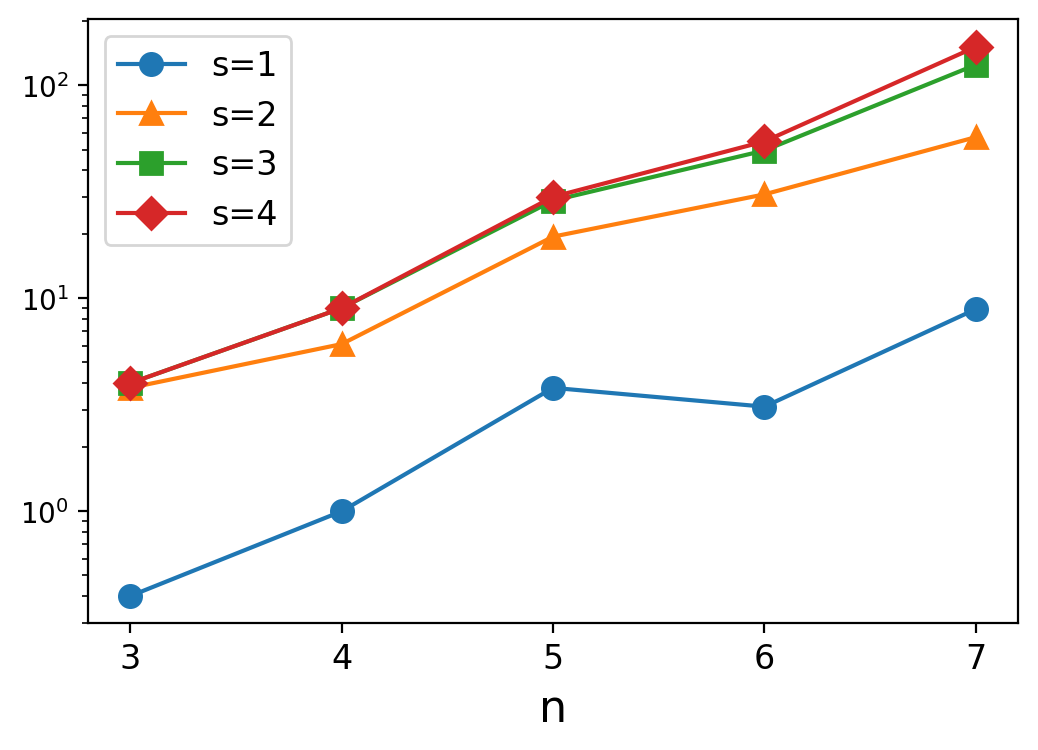

In [9]:
def plot_sparse(r, n_1, n_2, n_3, n_4):
    # libraries
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Data
    df=pd.DataFrame({ 'x_values': r, 's=1': n_1, 's=2': n_2, 's=3': n_3, 's=4': n_4 })

    # multiple line plots
    plt.plot( 'x_values', 's=1' , data=df, marker='o', markersize=8)
    plt.plot( 'x_values', 's=2' , data=df, marker='^', markersize=8)
    plt.plot( 'x_values', 's=3' , data=df, marker='s', markersize=8)
    plt.plot( 'x_values', 's=4' , data=df, marker='D', markersize=8)
    #plt.xticks(r) # force integer on x axis
    # show legend
    plt.legend()
    
    # config
    plt.legend(fontsize=12)
    plt.xticks(r, fontsize=12)
    plt.xlabel('n', fontsize=16)
    plt.gcf().set_dpi(200)
    plt.yscale('log')
    # show graph
    plt.show()

r_range = range(min_n, max_n+1)
n_1    = [r[1] for r in result_sparse if r[4]==1]
n_2    = [r[1] for r in result_sparse if r[4]==2]
n_3    = [r[1] for r in result_sparse if r[4]==3]
n_4    = [r[1] for r in result_sparse if r[4]==4]

plot_sparse(r_range, n_1, n_2, n_3, n_4)
    

# Random dense states

In [14]:
rnd = np.random.RandomState(42)

min_n = 3
max_n = 14

result = {}
for n in range(min_n, max_n+1):
    N = 2**n
    input_state = ((1.0 - 0.001) * rnd.rand(N) + 0.001) + ((1.0 - 0.001) * rnd.rand(N) + 0.001) * 1j
    input_state = input_state/np.linalg.norm(input_state)

    print('\nn = {0}:'.format(n))
    result[n] = _grid_search(input_state, strategy='greedy')



n = 3:
loss = 0.0:	CNOTs = 4	depth = 9	overlap=1.0
loss = 0.01:	CNOTs = 4	depth = 9	overlap=1.0
loss = 0.02:	CNOTs = 4	depth = 9	overlap=1.0
loss = 0.03:	CNOTs = 4	depth = 9	overlap=1.0
loss = 0.04:	CNOTs = 4	depth = 9	overlap=1.0
loss = 0.05:	CNOTs = 4	depth = 9	overlap=1.0
loss = 0.06:	CNOTs = 4	depth = 9	overlap=1.0
loss = 0.07:	CNOTs = 4	depth = 9	overlap=1.0
loss = 0.08:	CNOTs = 4	depth = 9	overlap=1.0
loss = 0.09:	CNOTs = 4	depth = 9	overlap=1.0
loss = 0.1:	CNOTs = 4	depth = 9	overlap=1.0
loss = 0.11:	CNOTs = 4	depth = 9	overlap=1.0
loss = 0.12:	CNOTs = 4	depth = 9	overlap=1.0
loss = 0.13:	CNOTs = 4	depth = 9	overlap=1.0
loss = 0.14:	CNOTs = 1	depth = 3	overlap=0.8639963820714042
loss = 0.15:	CNOTs = 1	depth = 3	overlap=0.8639963820714042
loss = 0.16:	CNOTs = 1	depth = 3	overlap=0.8639963820714042
loss = 0.17:	CNOTs = 1	depth = 3	overlap=0.8639963820714042
loss = 0.18:	CNOTs = 1	depth = 3	overlap=0.8639963820714042
loss = 0.19:	CNOTs = 1	depth = 3	overlap=0.8639963820714042
loss

# Plot dense results

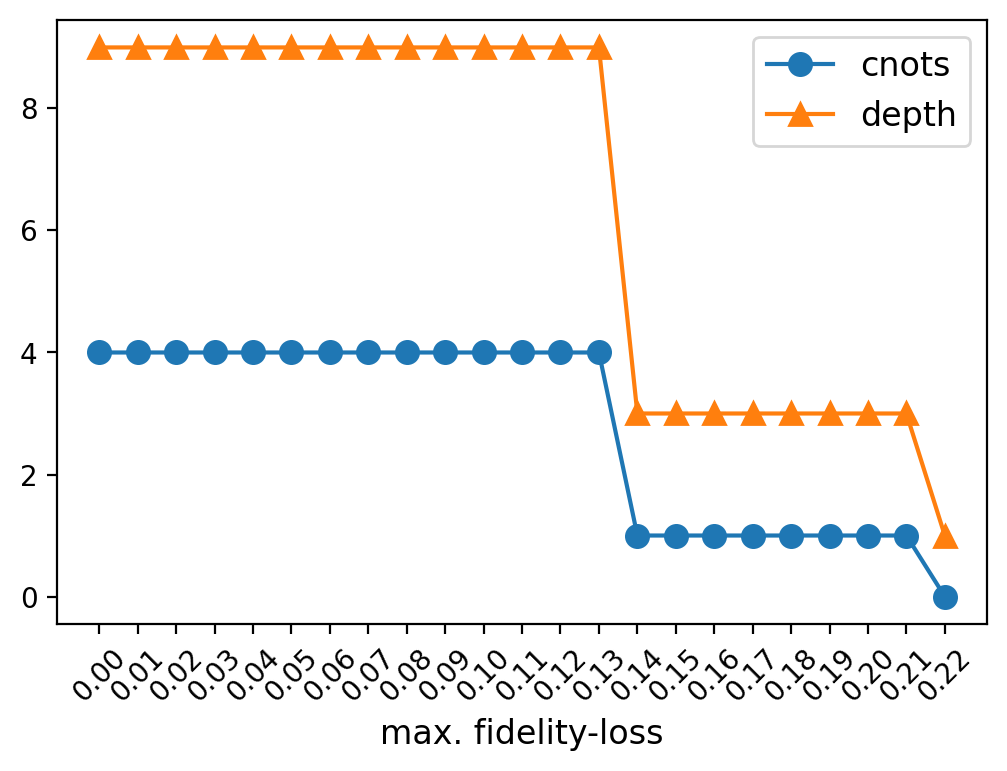

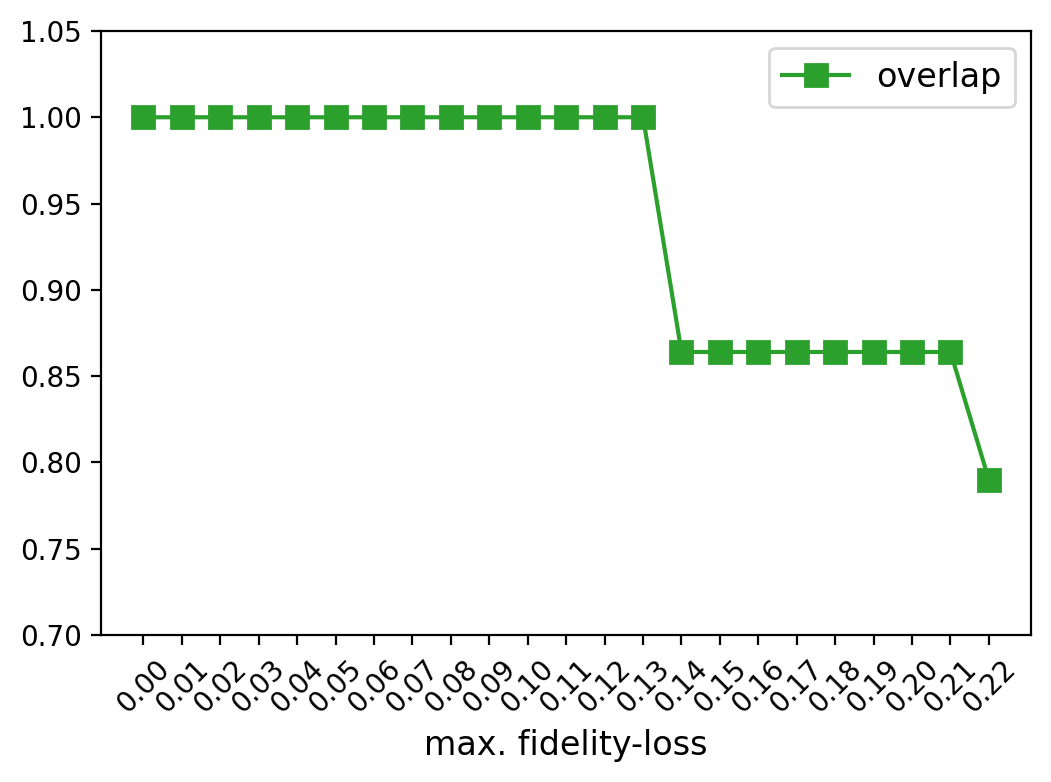

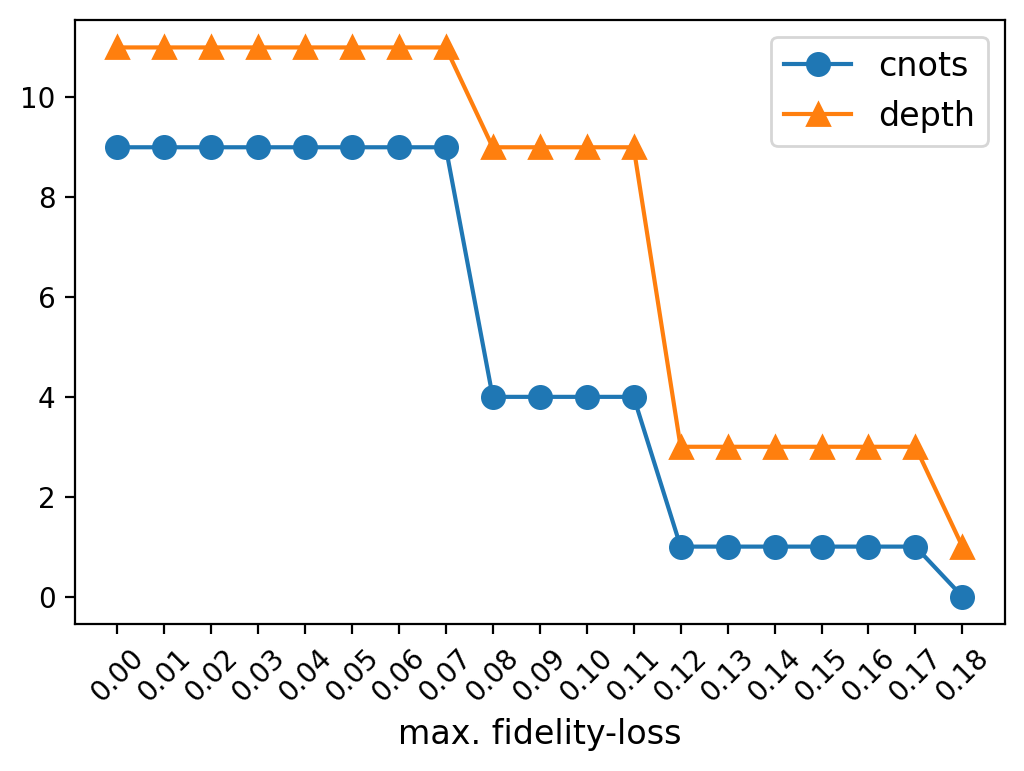

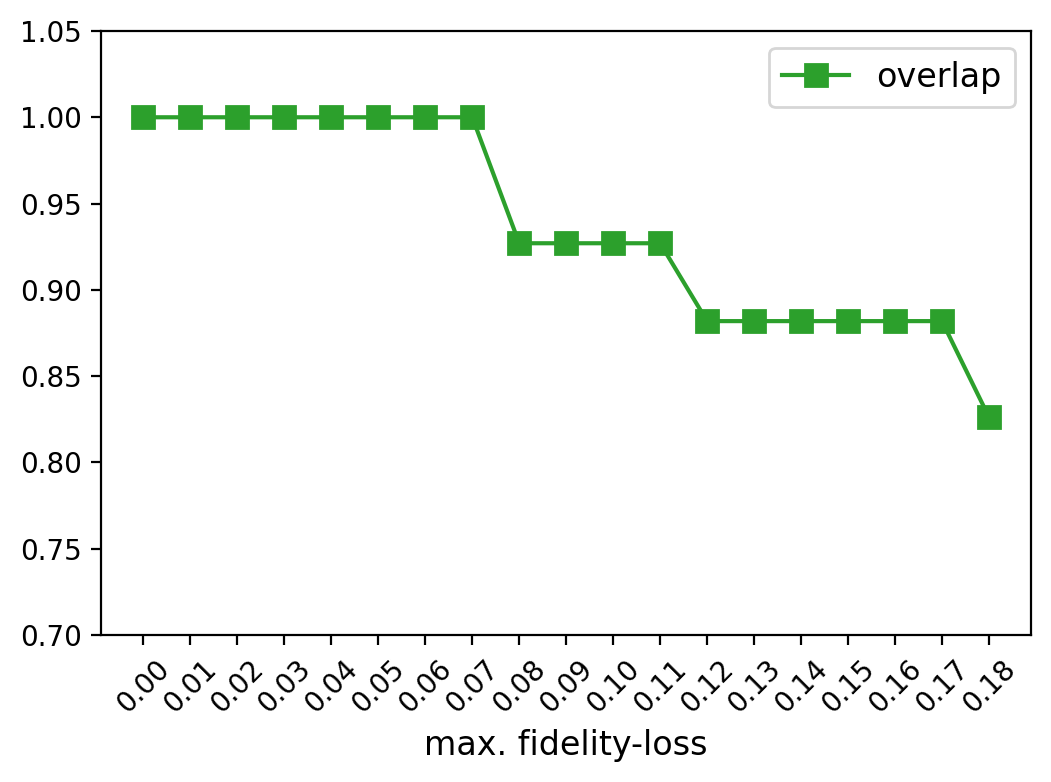

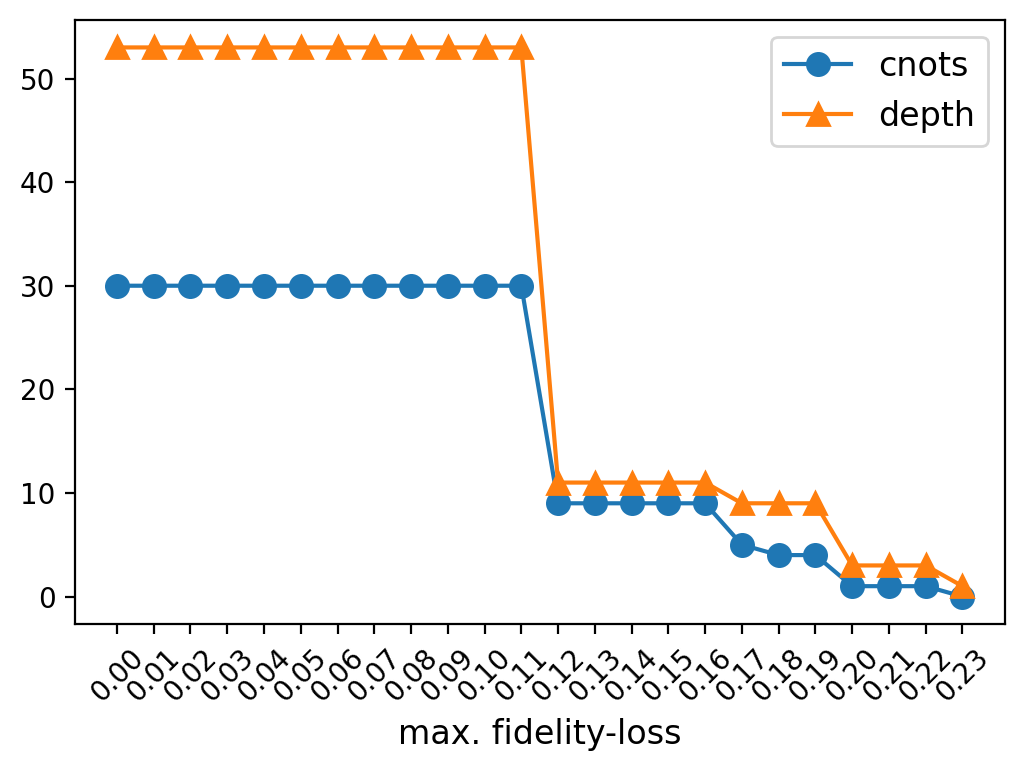

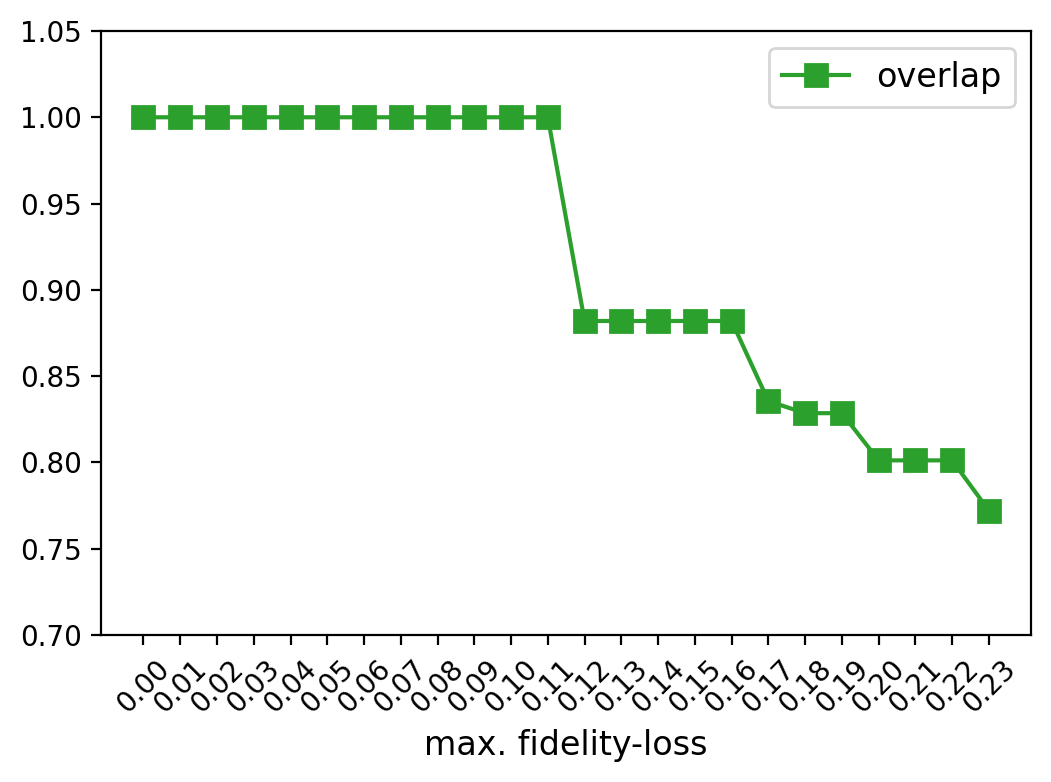

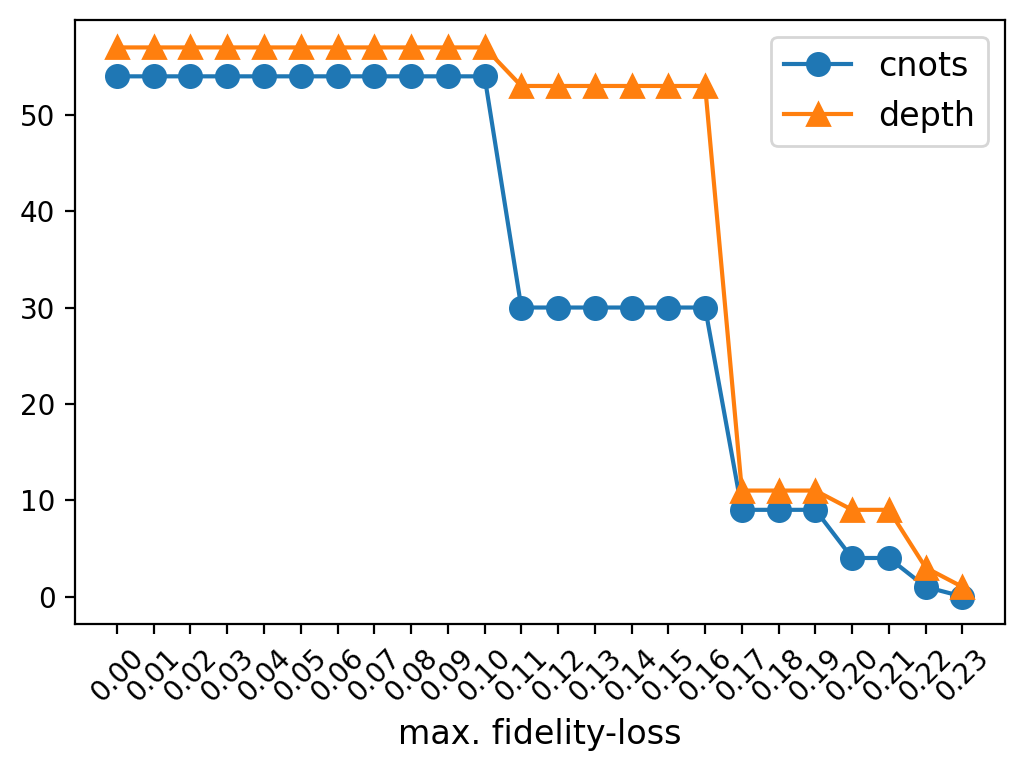

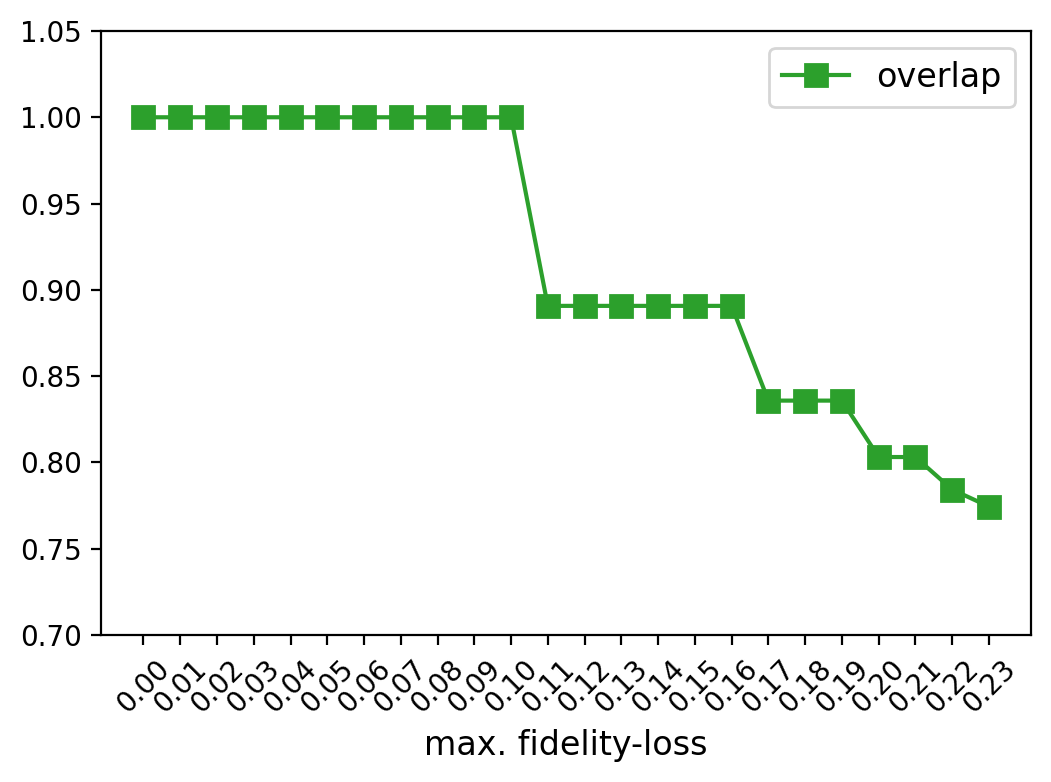

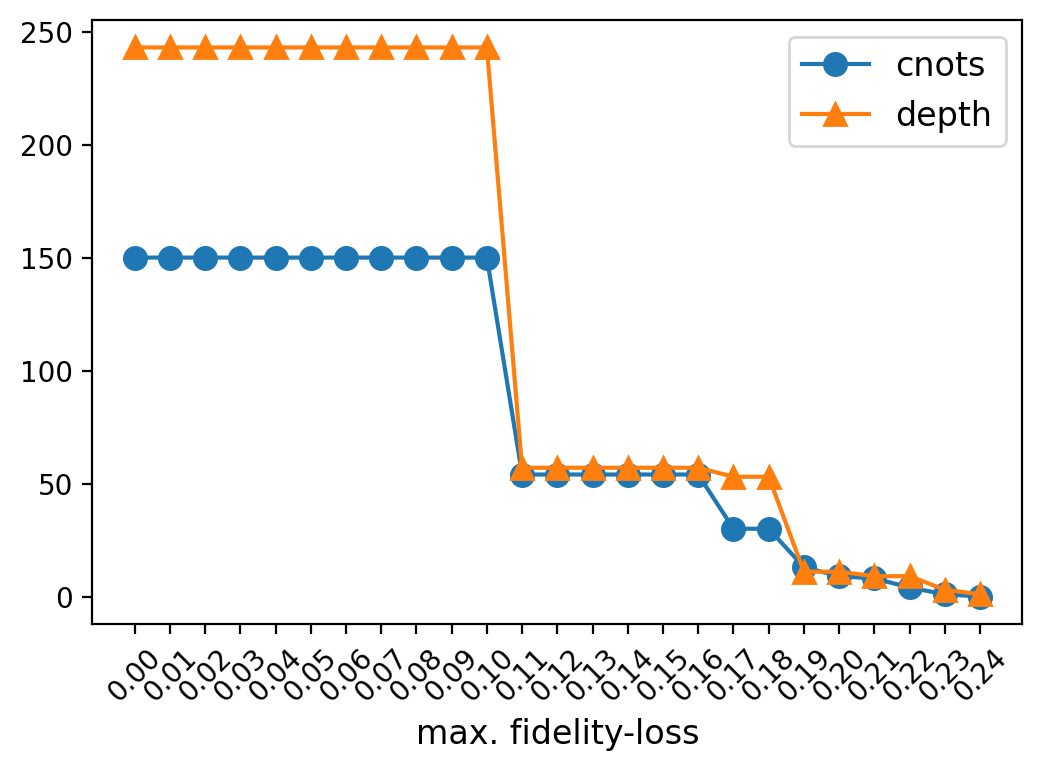

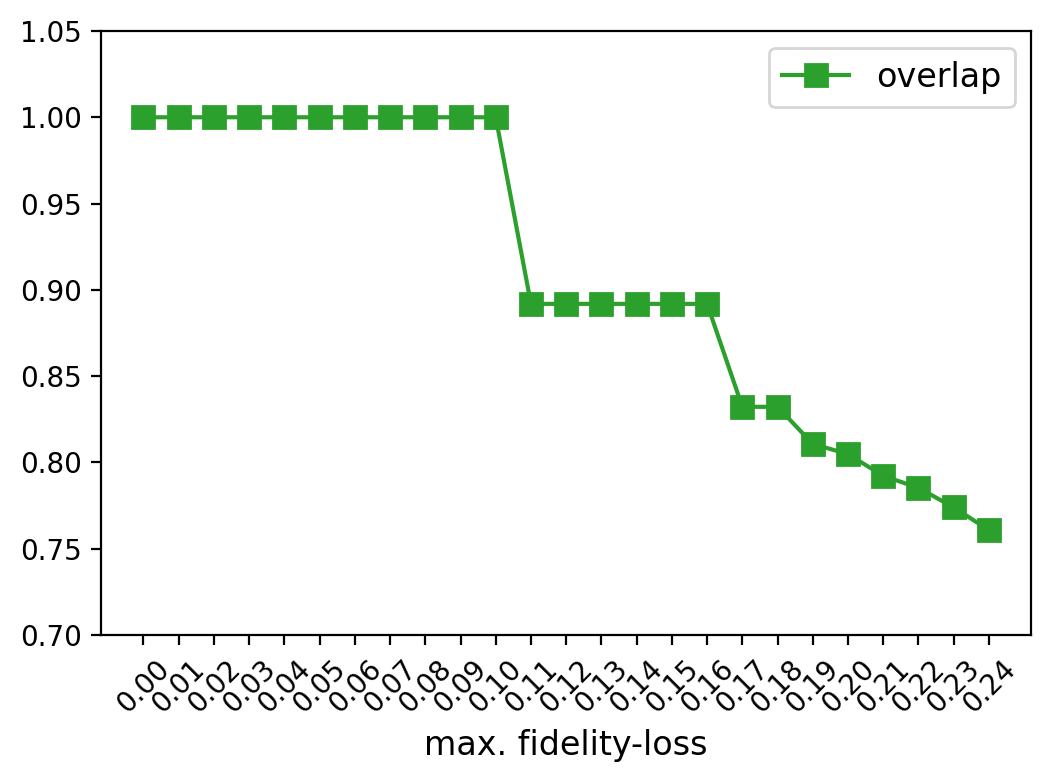

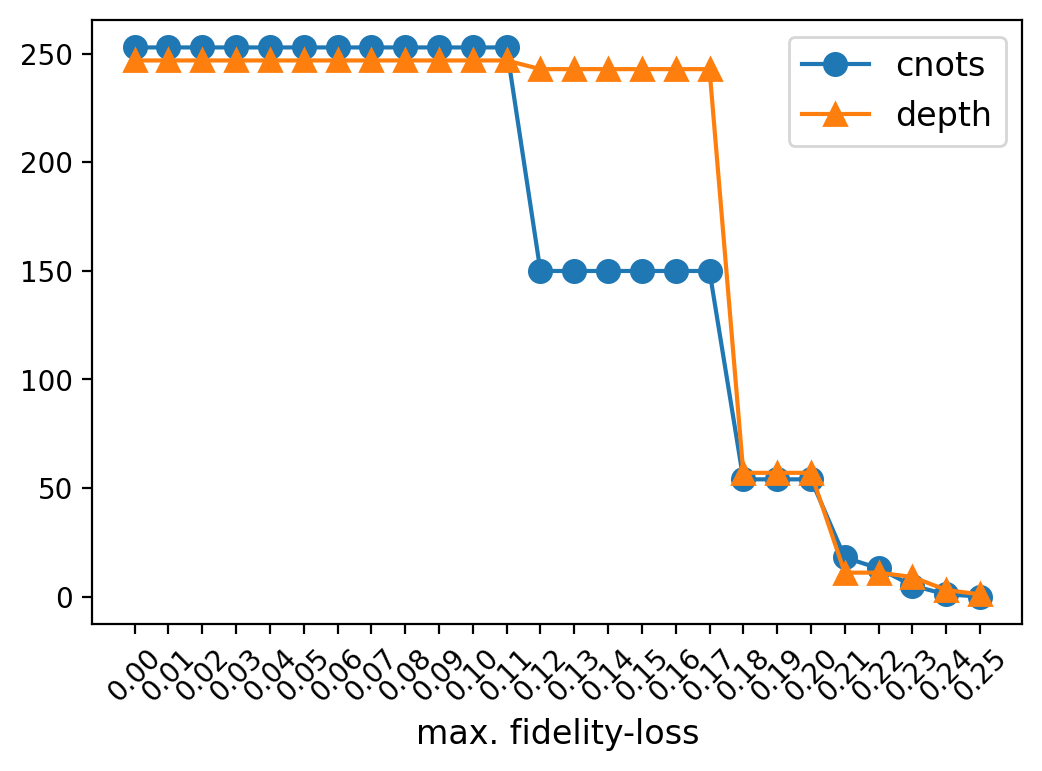

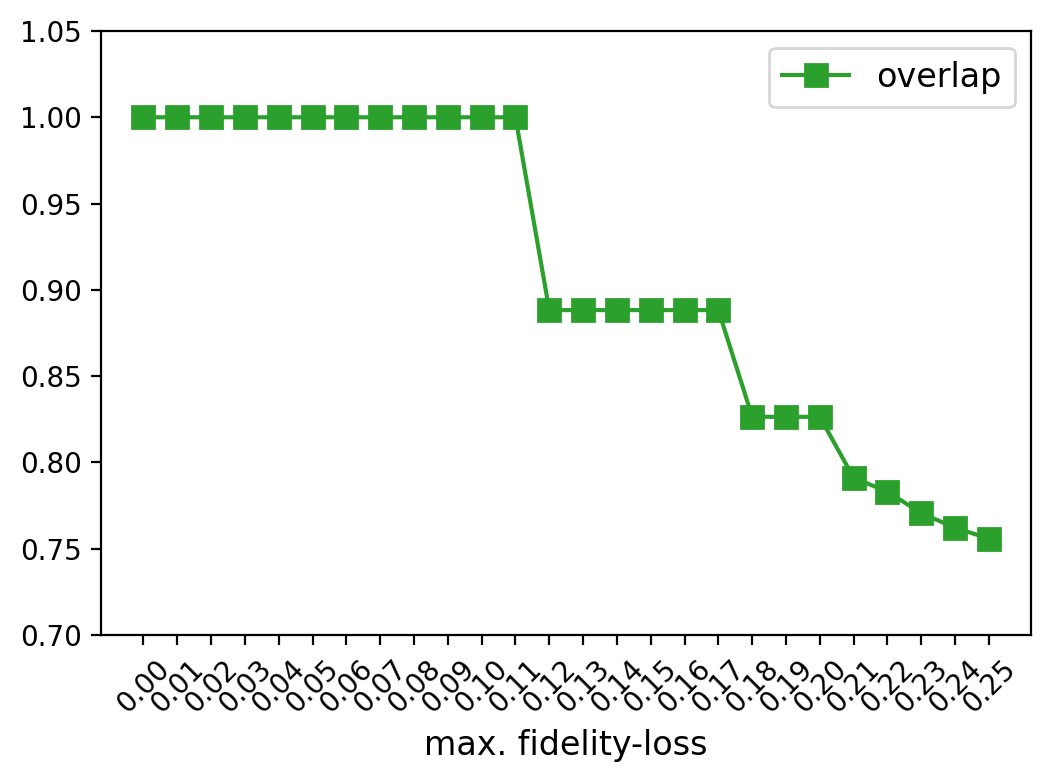

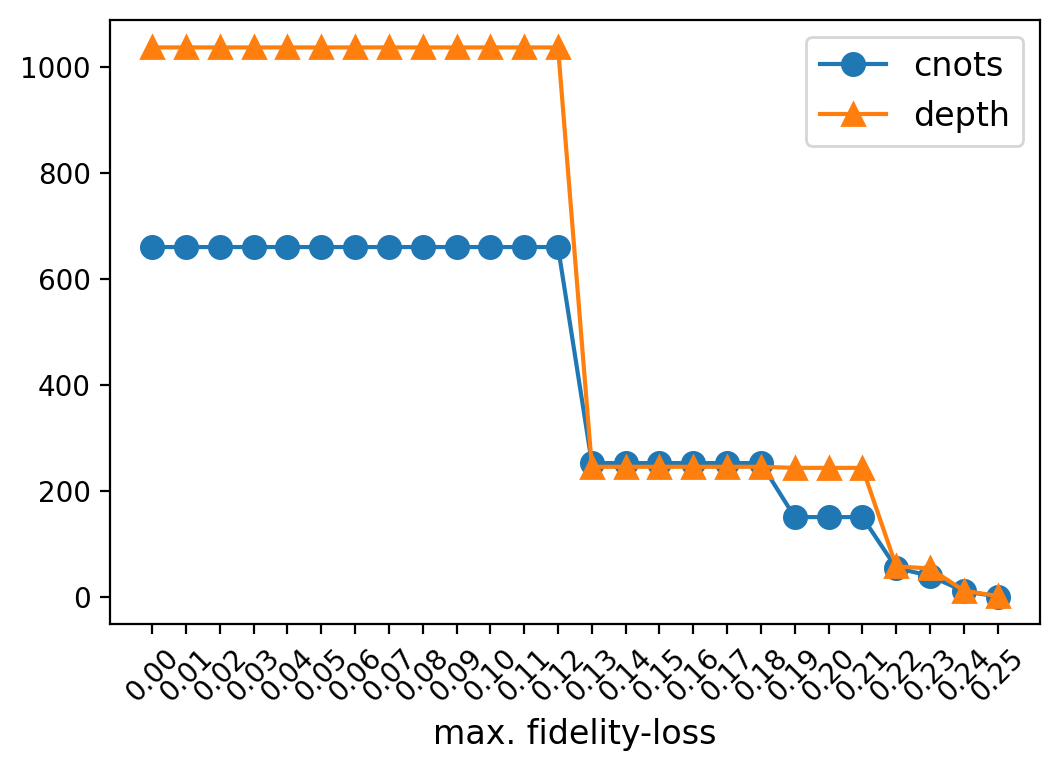

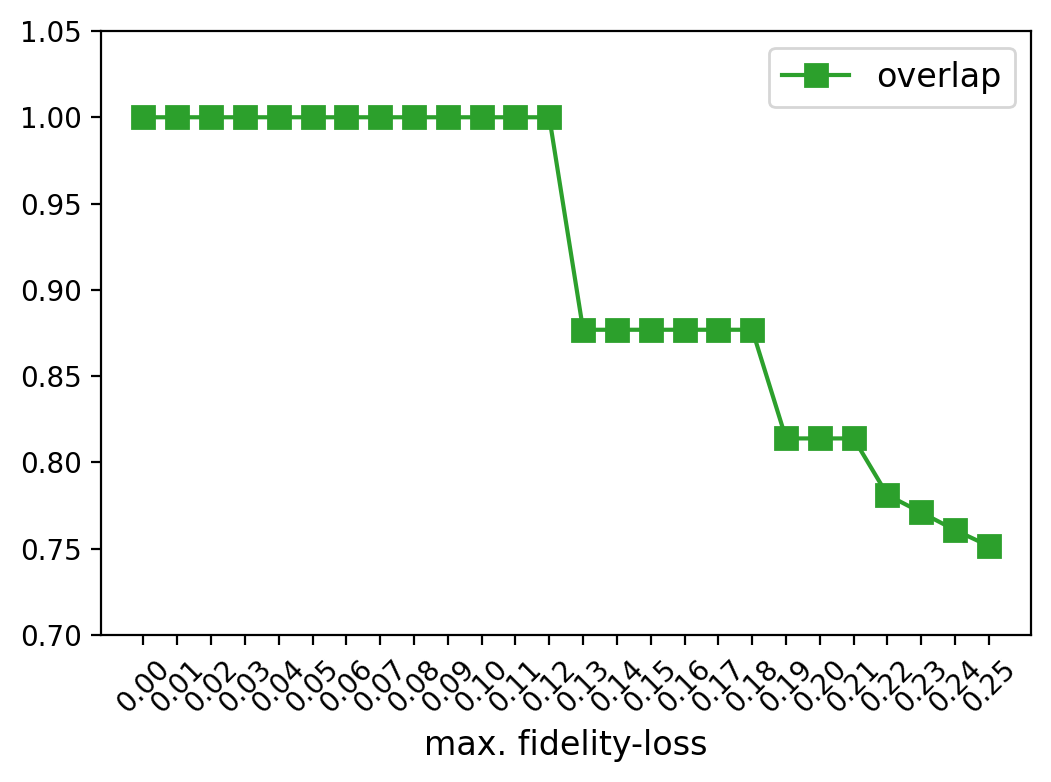

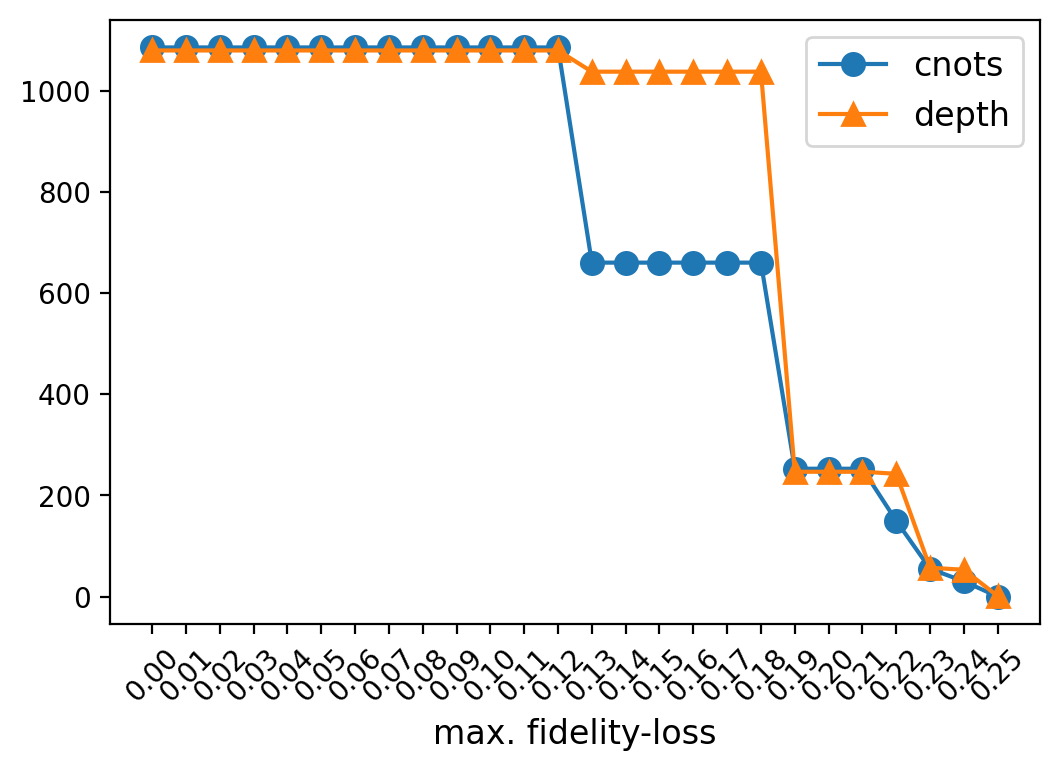

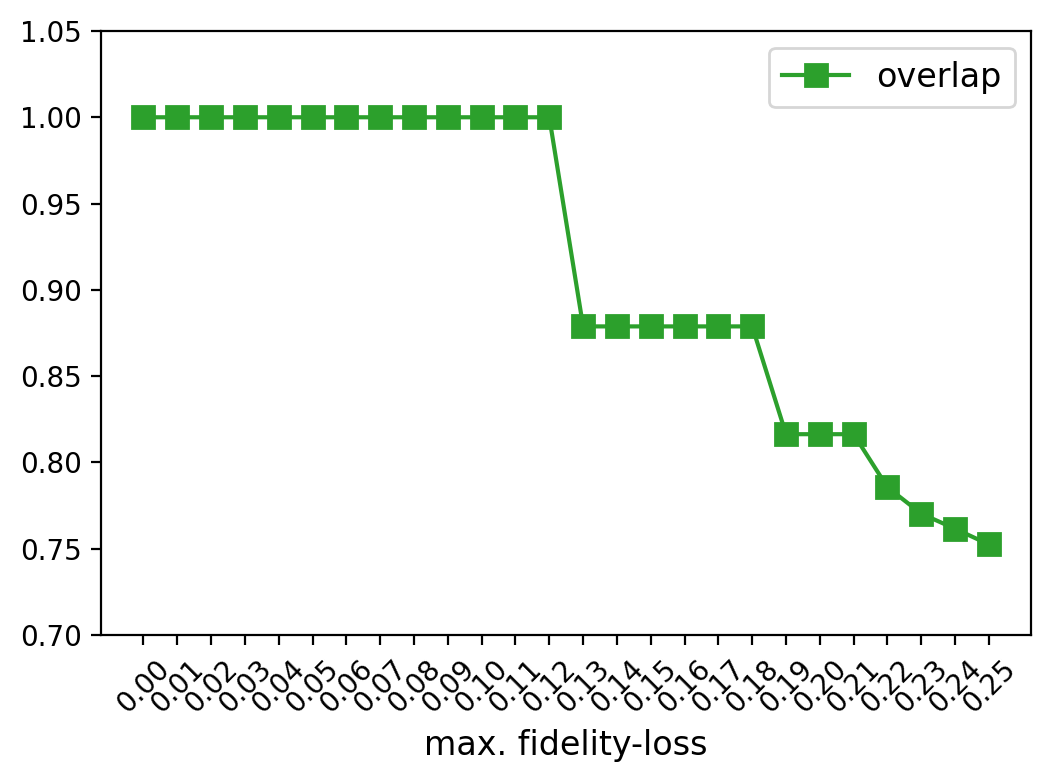

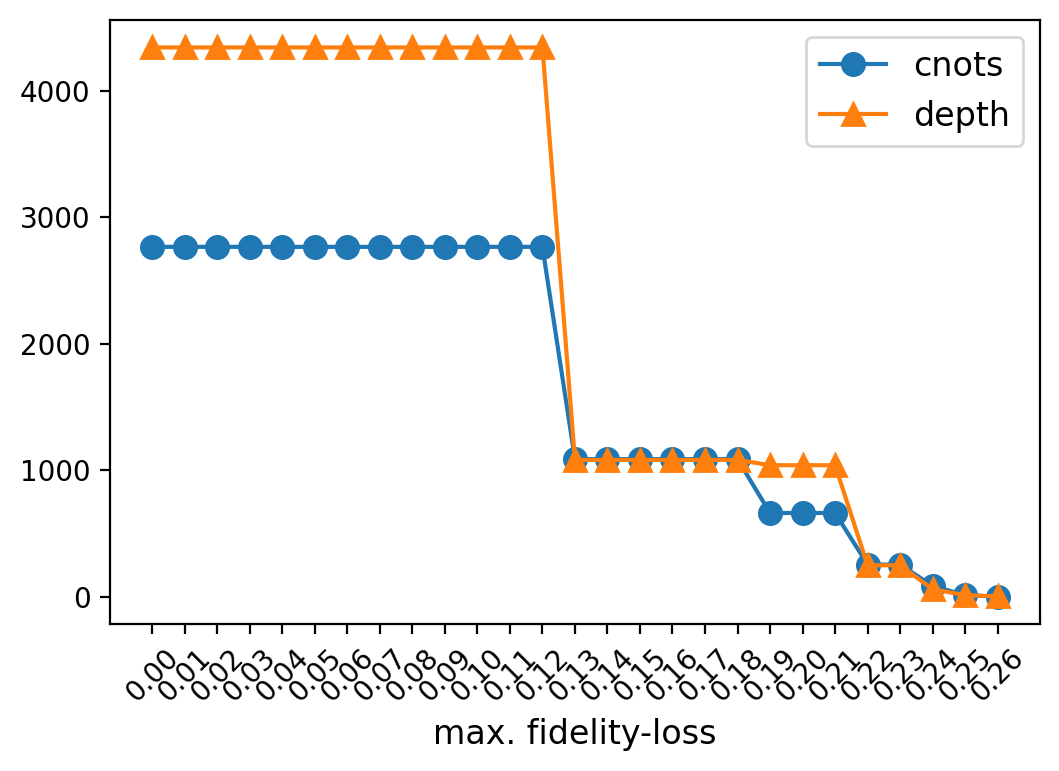

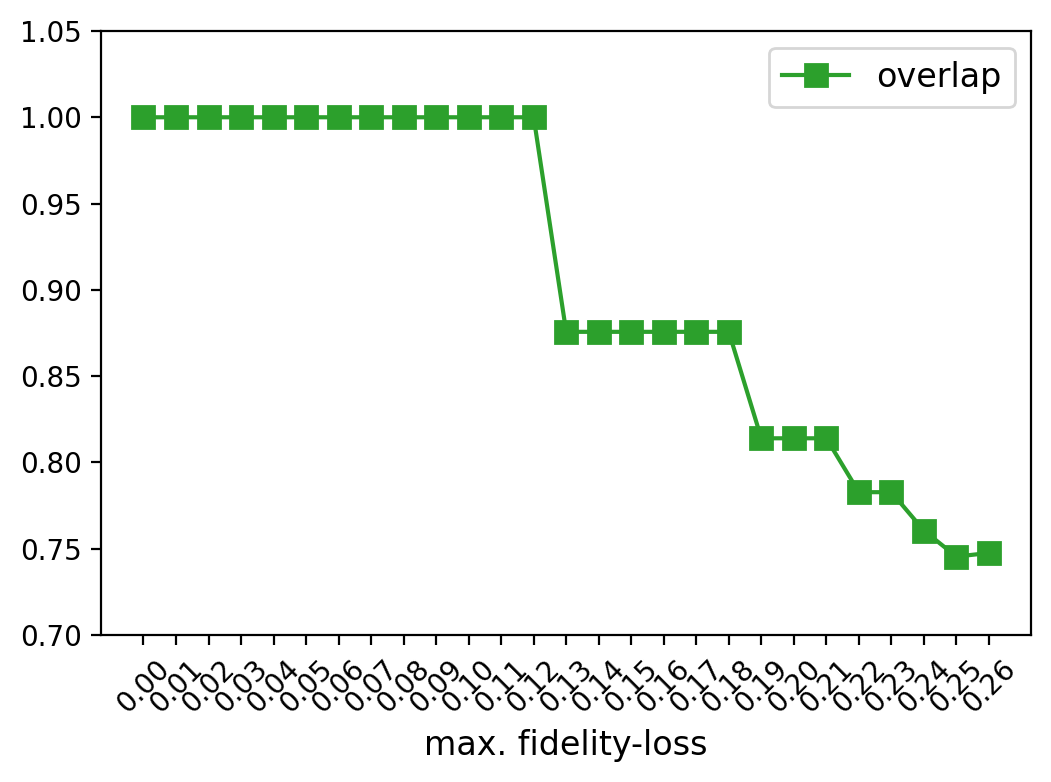

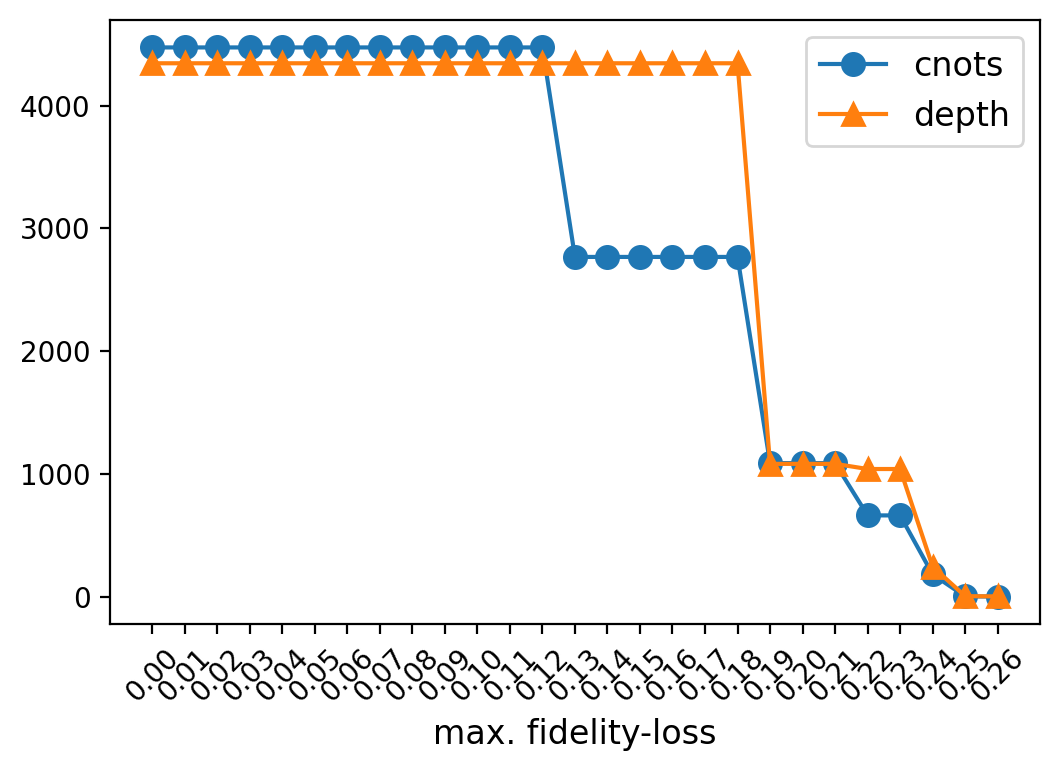

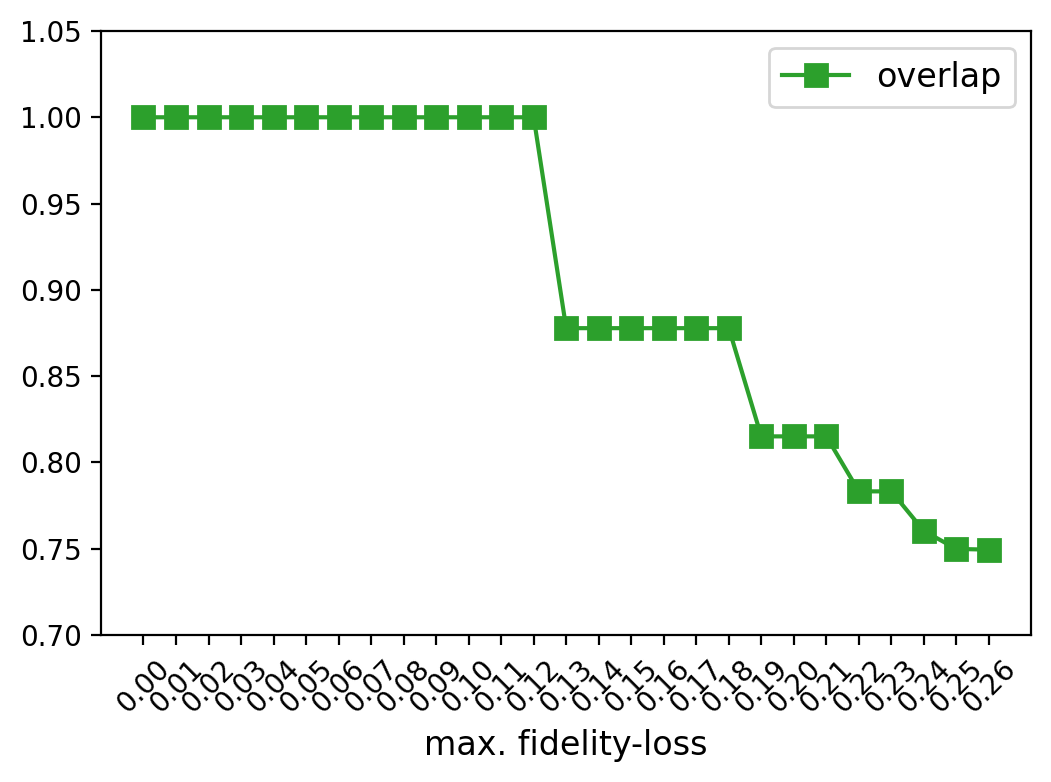

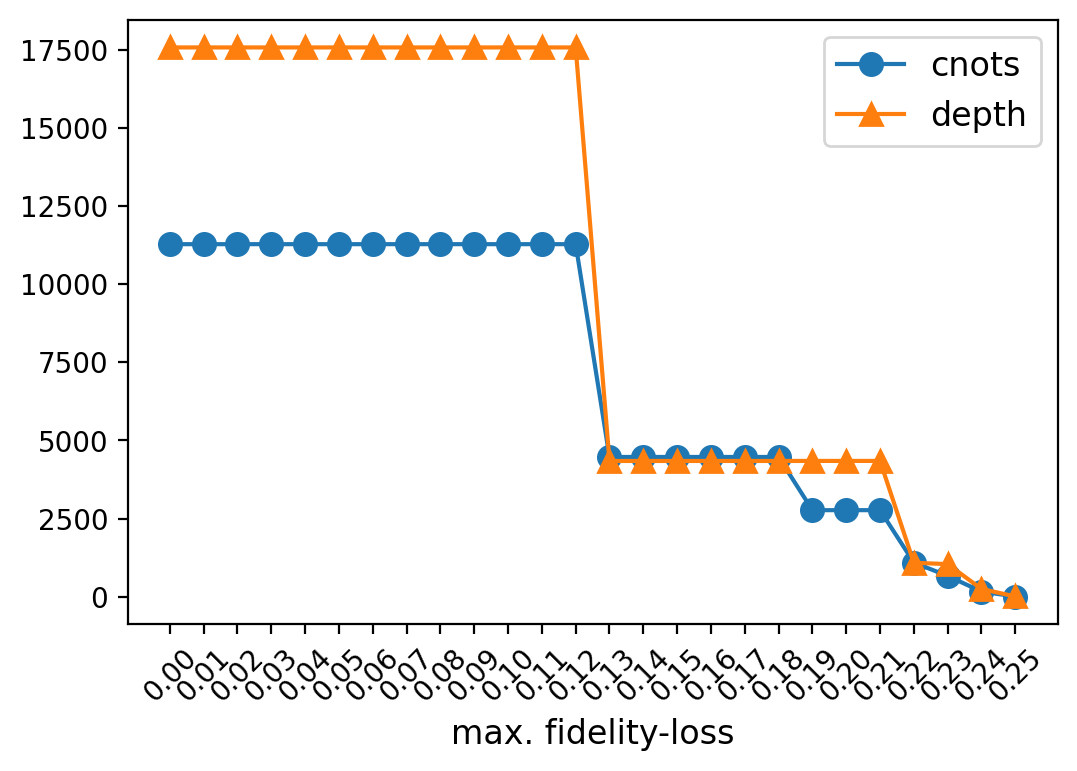

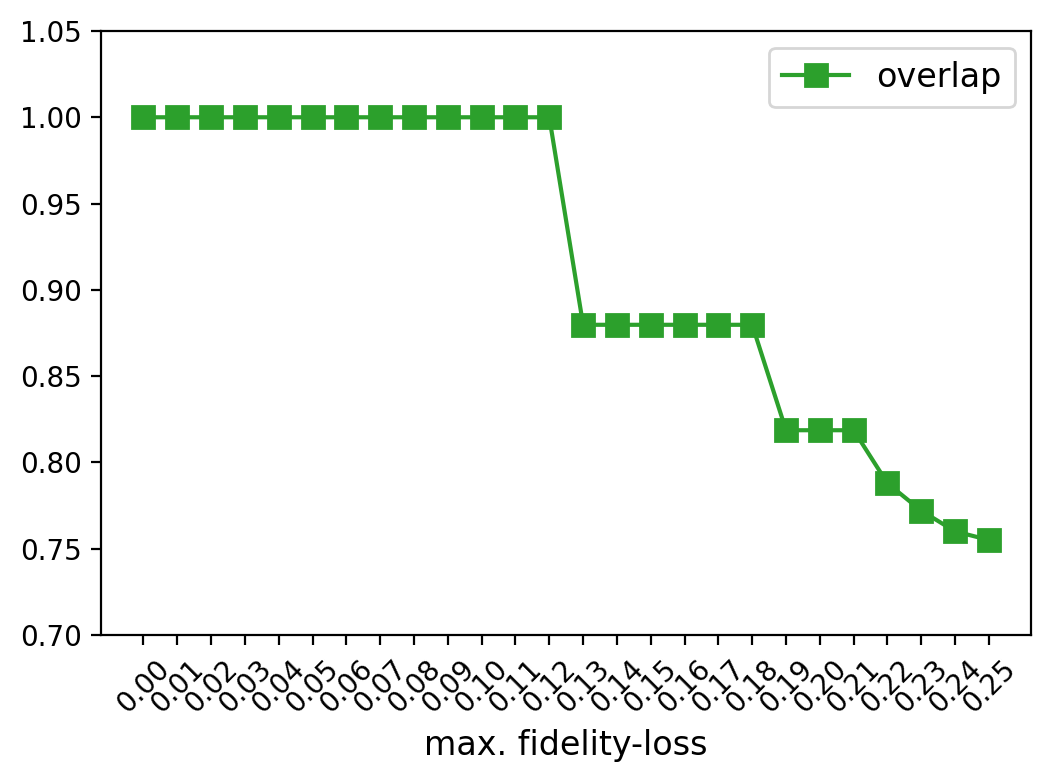

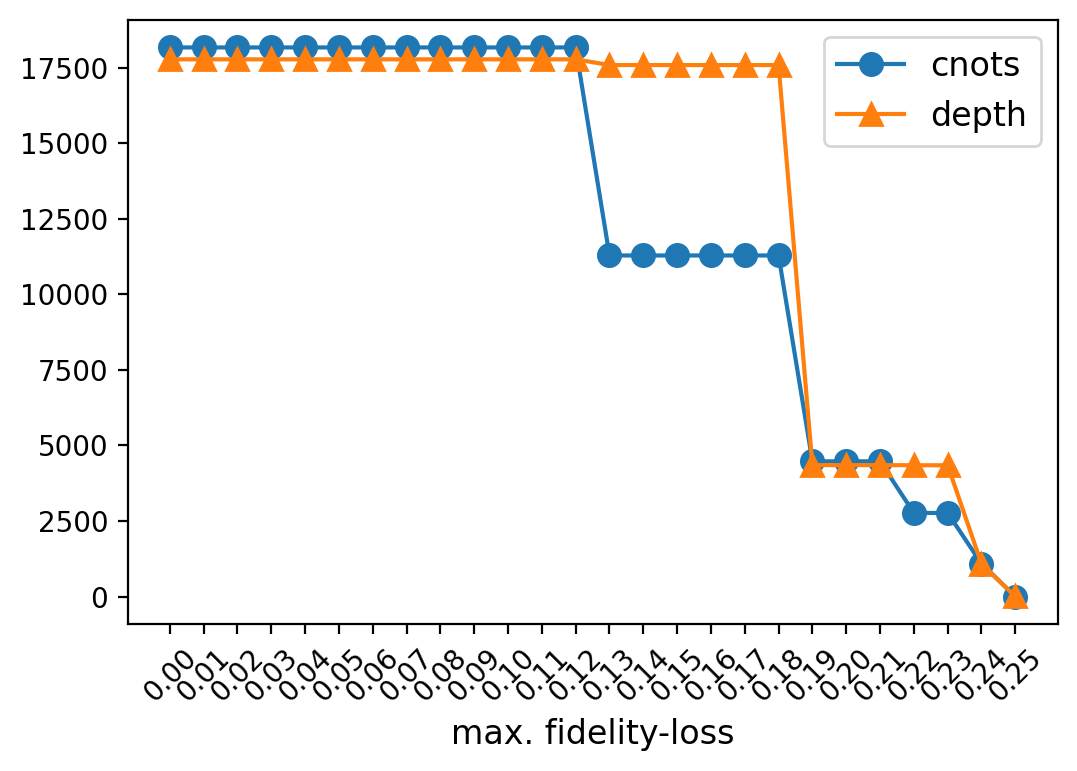

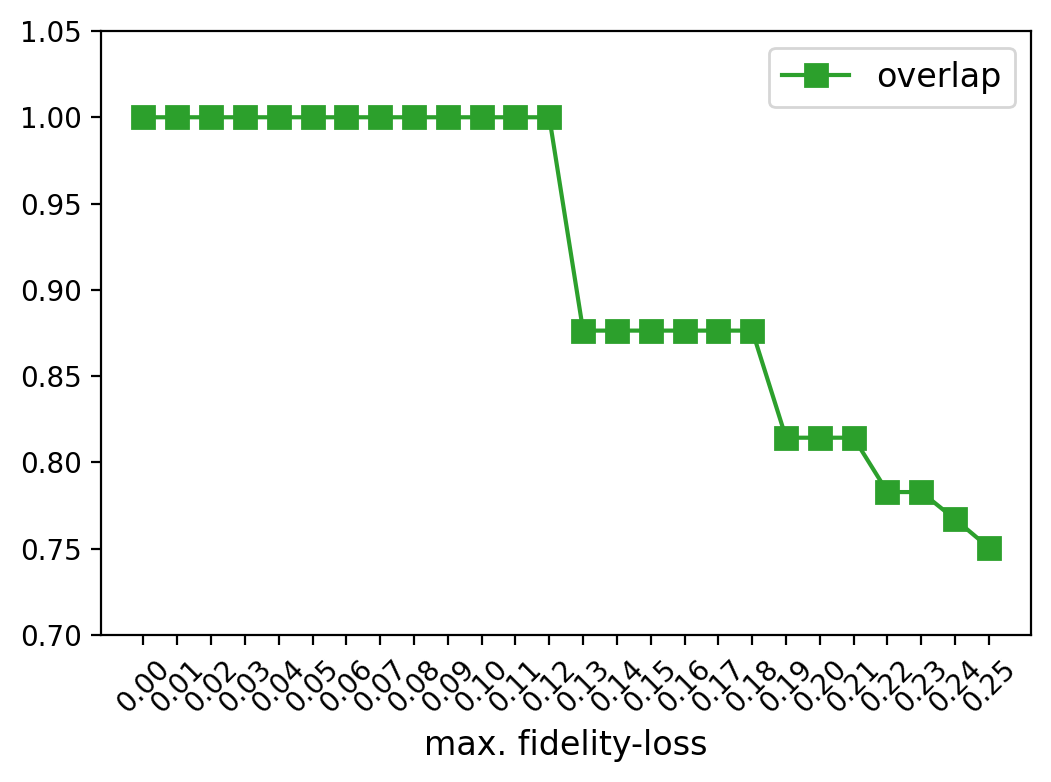

In [19]:
def plot1(r, overlap):
    # libraries
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from matplotlib.ticker import FormatStrFormatter

    # Data
    df=pd.DataFrame({ 'x_values': r, 'overlap': overlap })

    # multiple line plots
    plt.plot( 'x_values', 'overlap', 'C2' , data=df, marker='s', markersize=8)
    plt.xticks(r) # force integer on x axis
    # show legend
    plt.legend()
    
    # config
    plt.legend(fontsize=12)
    plt.xticks(r, fontsize=10, rotation=45)
    plt.xlabel('max. fidelity-loss', fontsize=12)
    plt.gcf().set_dpi(200)
    
    # format y axis numbers
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_ylim([0.7, 1.05])

    # show graph
    plt.show()

def plot2(r, n_cx, n_dp):
    # libraries
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Data
    df=pd.DataFrame({ 'x_values': r, 'cnots': n_cx, 'depth': n_dp })

    # multiple line plots
    plt.plot( 'x_values', 'cnots' , data=df, marker='o', markersize=8)
    plt.plot( 'x_values', 'depth' , data=df, marker='^', markersize=8)
    #plt.xticks(r) # force integer on x axis
    # show legend
    plt.legend()
    
    # config
    plt.legend(fontsize=12)
    plt.xticks(r, fontsize=10, rotation=45)
    plt.xlabel('max. fidelity-loss', fontsize=12)
    plt.gcf().set_dpi(200)
    
    # show graph
    plt.show()

def plot_result(n, result):
    r_range = [r[0] for r in result[n]]
    n_cx    = [r[1] for r in result[n]]
    n_dp    = [r[2] for r in result[n]]

    plot2(r_range, n_cx, n_dp)

def plot_overlap(n, result):
    r_range = [r[0] for r in result[n]]
    overlap = [r[3] for r in result[n]]

    plot1(r_range, overlap)

for n in range(min_n, max_n+1):
    plot_result(n, result)
    plot_overlap(n, result)